# Import 

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import AllChem, DataStructs
from datasketch import MinHash, MinHashLSH
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

In [3]:
model = "dinov2_g"
base_path = Path("/projects/synsight/data/jump_embeddings/compounds_embeddings/")
parquet_metadata = base_path / model / Path("metadata.parquet")
jump_df = pd.read_parquet(parquet_metadata)

In [4]:
embeddings_path = base_path / model / "Embeddings_norm.npy"
embeddings = np.load(embeddings_path)

# Phenotypic SALI

In [7]:
FP_RADIUS = 2  # Morgan (ECFP4 ≈ radius=2)
FP_NBITS = 1024
TAN_THRESH = 0.60  # seuil de similarité structurelle
EPS = 1e-6
N_JOBS = 75  # joblib
# MinHash/LSH params (compromis précision/temps/mémoire)
NUM_PERM = 128
LSH_THRESH = 0.60  # seuil LSH ~ seuil Tanimoto visé (approx)

In [8]:
X = embeddings

jump_df_test = jump_df.sample(n=50_000, random_state=42).reset_index(drop=True)
X = X[jump_df.index]

In [9]:
from rdkit import RDLogger

RDLogger.DisableLog("rdApp.*")  # coupe les logs RDKit (ne change rien au calcul)

In [10]:
_morgan_gen = rdFingerprintGenerator.GetMorganGenerator(
    radius=FP_RADIUS, fpSize=FP_NBITS
)


def inchi_to_fp_and_set(inchi: str, radius=FP_RADIUS, nBits=FP_NBITS):
    try:
        mol = Chem.MolFromInchi(inchi, sanitize=True)
        if mol is None:
            return None, None
        fp = _morgan_gen.GetFingerprint(mol)  # ExplicitBitVect
        onbits = list(fp.GetOnBits())
        return fp, set(onbits)
    except Exception:
        return None, None


def cosine_dist(vec_i, vec_j):
    cs = cosine_similarity(vec_i.reshape(1, -1), vec_j.reshape(1, -1))[0, 0]
    return 1.0 - cs


def tanimoto(fp_i, fp_j):
    return DataStructs.TanimotoSimilarity(fp_i, fp_j)


# ---------------------------
# Build MinHash LSH index (structure)
# ---------------------------
def mk_minhash(bits_set, num_perm=NUM_PERM):
    mh = MinHash(num_perm=num_perm)
    # MinHash attend des "tokens"; ici on passe les indices de bits sous forme de str
    for b in bits_set:
        mh.update(str(b).encode("utf-8"))
    return mh

In [ ]:
assert X.shape[0] == len(jump_df), "embeddings and df length mismatch"

# 0) Ensure float + L2-normalize ONCE (after aligning with valid_idx)
X = X.astype(np.float32, copy=False)
norms = np.linalg.norm(X, axis=1, keepdims=True)
Xn = X / (norms + 1e-12)  # unit vectors


# 1) Robust cosine distance (no sklearn, no deprecation)
def cosine_dist_unit(u, v):
    # u and v MUST be L2-normalized rows from Xn
    # cosine distance = 1 - (u·v)
    cs = float(np.dot(u, v))
    # Clamp numerical noise
    if cs > 1.0:
        cs = 1.0
    elif cs < -1.0:
        cs = -1.0
    return 1.0 - cs


inchis = jump_df["Metadata_InChI"].tolist()
res = Parallel(n_jobs=N_JOBS, prefer="threads")(
    delayed(inchi_to_fp_and_set)(i) for i in tqdm(inchis)
)
fps, bitsets = zip(*res)

valid_idx = [
    i
    for i, (fp, bs) in enumerate(zip(fps, bitsets))
    if (fp is not None and bs is not None and len(bs) > 0)
]
if len(valid_idx) < len(fps):
    print(
        f"[Info] Dropping {len(fps)-len(valid_idx)} molecules with invalid/empty fingerprints."
    )
    jump_df = jump_df.iloc[valid_idx].reset_index(drop=True)
    X = X[valid_idx]
    fps = [fps[i] for i in valid_idx]
    bitsets = [bitsets[i] for i in valid_idx]

N = len(jump_df)
print(f"[Info] Kept {N} molecules.")


print("[Info] Building MinHash signatures...")
minhashes = Parallel(n_jobs=N_JOBS, prefer="threads")(
    delayed(mk_minhash)(s) for s in bitsets
)

print("[Info] Inserting into LSH index...")
lsh = MinHashLSH(threshold=LSH_THRESH, num_perm=NUM_PERM)
for i, mh in enumerate(minhashes):
    lsh.insert(str(i), mh)


def candidates_for_i(i):
    mh = minhashes[i]
    cand_keys = lsh.query(mh)  # clés str
    cand = []
    ii = int(i)
    for key in cand_keys:
        jj = int(key)
        if jj <= ii:
            continue  # éviter doublons et self
        tan = tanimoto(fps[ii], fps[jj])
        if tan >= TAN_THRESH:
            dcos = cosine_dist_unit(Xn[ii], Xn[jj])

            sali = dcos / (1.0 - tan + EPS)
            cand.append((ii, jj, tan, dcos, sali))
    return cand


print("[Info] Generating candidate pairs and computing SALI_pheno...")
pairs = Parallel(n_jobs=N_JOBS, prefer="threads")(
    delayed(candidates_for_i)(i) for i in tqdm(range(N))
)
pairs = [p for row in pairs for p in row]  # flatten

sali_df = pd.DataFrame(
    pairs, columns=["idx_i", "idx_j", "tanimoto", "cosine_distance", "SALI_pheno"]
)
print(
    f"[Info] Retained {len(sali_df)} structural pairs with Tanimoto >= {TAN_THRESH:.2f}"
)

sali_df["InChI_ID_i"] = jump_df.loc[sali_df["idx_i"], "Metadata_InChI_ID"].to_numpy()
sali_df["InChI_ID_j"] = jump_df.loc[sali_df["idx_j"], "Metadata_InChI_ID"].to_numpy()

 26%|██▌       | 28950/112480 [05:24<12:05, 115.13it/s]

In [ ]:
sali_df.to_csv("sali.csv", index=False)

In [ ]:
sali_df[(sali_df["SALI_pheno"] < 100_000) & (sali_df["SALI_pheno"] > 60)]

,idx_i,idx_j,tanimoto,cosine_distance,SALI_pheno,InChI_ID_i,InChI_ID_j
143,34,2246,0.984848,1.002019,66.128864,34,2246
5125,1679,4987,0.984848,0.955328,63.047492,1679,4987
5349,1767,41754,0.984375,1.118195,71.559913,1767,41757
6465,2174,40746,0.984615,1.088202,70.728503,2174,40749
7887,2710,2897,0.986111,0.874818,62.982395,2710,2897
13046,5150,40979,0.984375,1.085570,69.472057,5150,40982
27154,27224,30307,0.983051,1.059092,62.482767,27226,30309
27760,27737,31424,0.980392,1.218233,62.126735,27739,31426
30326,29960,33212,0.983333,1.037547,62.249098,29962,33214
32868,32795,33195,0.983051,1.092641,64.462020,32797,33197


In [ ]:
if "Metadata_JCP2022" in jump_df.columns:
    sali_df["JCP2022_i"] = jump_df.loc[sali_df["idx_i"], "Metadata_JCP2022"].to_numpy()
    sali_df["JCP2022_j"] = jump_df.loc[sali_df["idx_j"], "Metadata_JCP2022"].to_numpy()
else:
    print("[WARN] Metadata_JCP2022 column not found in jump_df.")

In [ ]:
sali_df_no_outlier = sali_df[sali_df["SALI_pheno"] < 100_000]

In [ ]:
sali_df_no_outlier[
    (sali_df_no_outlier["cosine_distance"] > 1.4)
    & (sali_df_no_outlier["tanimoto"] >= 0.9)
    # & (sali_df_no_outlier["tanimoto"] < 0.9)
    & (sali_df_no_outlier["SALI_pheno"] > 10)
]

,idx_i,idx_j,tanimoto,cosine_distance,SALI_pheno,InChI_ID_i,InChI_ID_j,JCP2022_i,JCP2022_j
64369,108971,110817,0.927536,1.428651,19.715107,108982,110837,JCP2022_039190,JCP2022_075041


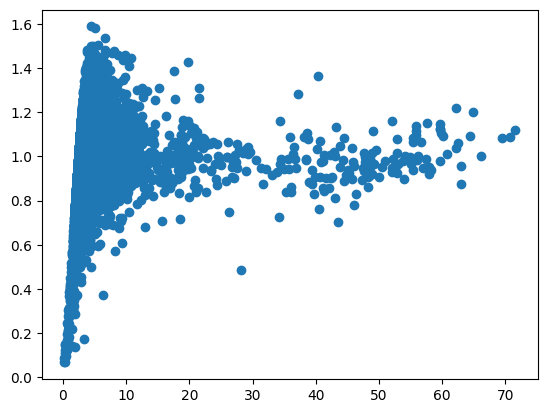

In [ ]:
plt.scatter(sali_df_no_outlier["SALI_pheno"], sali_df_no_outlier["cosine_distance"])

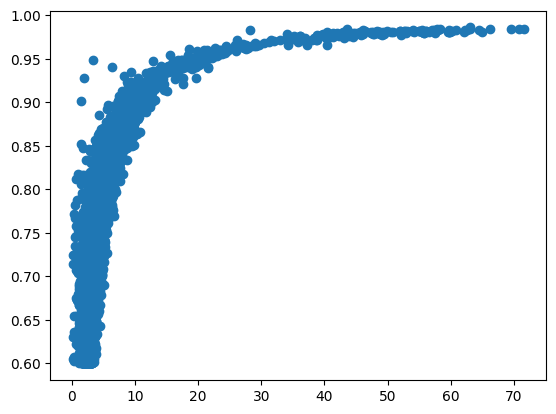

In [ ]:
plt.scatter(sali_df_no_outlier["SALI_pheno"], sali_df_no_outlier["tanimoto"])

In [ ]:
sali_df_no_outlier

,idx_i,idx_j,tanimoto,cosine_distance,SALI_pheno,InChI_ID_i,InChI_ID_j
0,2,41537,0.716667,0.989043,3.490729,2,41540
1,3,2069,0.750000,0.974411,3.897627,3,2069
2,3,103159,0.722222,0.944595,3.400531,3,103162
3,3,2098,0.600000,0.939003,2.347500,3,2098
4,3,40753,0.732143,1.050834,3.923101,3,40756
...,...,...,...,...,...,...,...
64728,112374,112383,0.692308,0.909326,2.955300,112428,112437
64729,112383,112387,0.646154,1.034452,2.923444,112437,112441
64730,112383,112386,0.656250,1.069474,3.111188,112437,112440
64731,112386,112387,0.842105,1.101946,6.978947,112440,112441


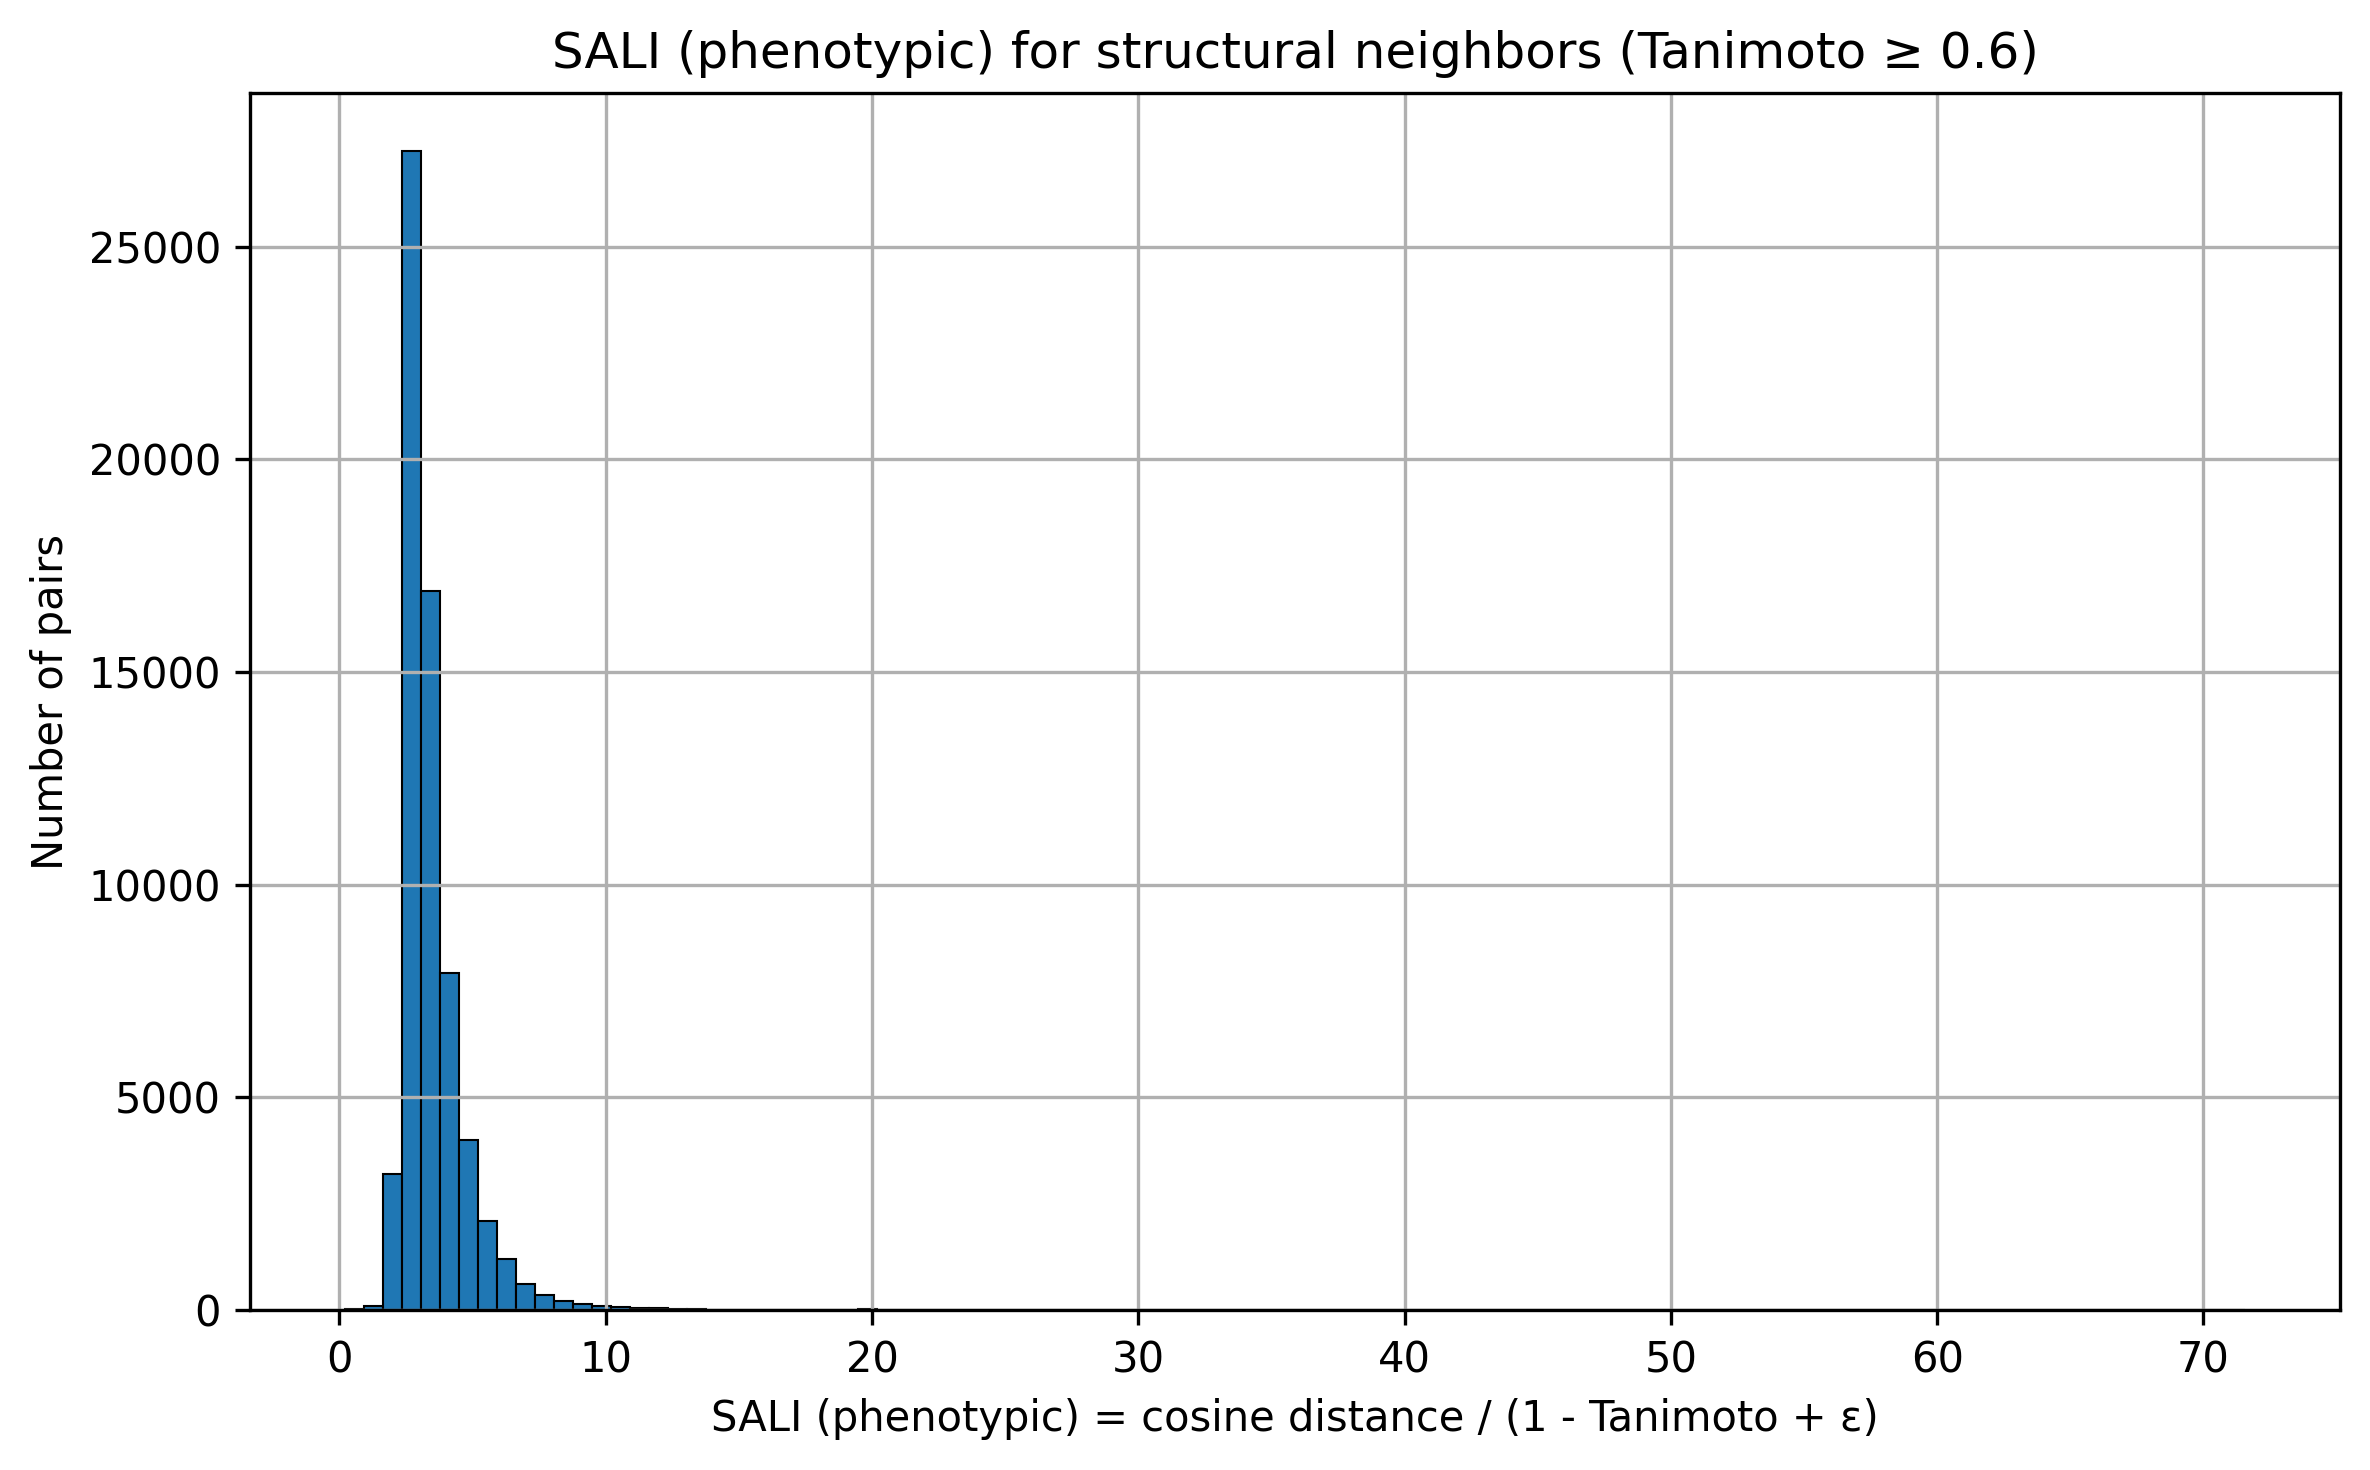

count    6.473300e+04
mean     9.233159e+02
std      3.044522e+04
min      2.234009e-01
25%      2.717315e+00
50%      3.129174e+00
75%      3.861829e+00
max      1.266018e+06
Name: SALI_pheno, dtype: float64


In [ ]:
# ---------------------------
# Histogramme HD
# ---------------------------
plt.figure(figsize=(8, 5), dpi=300)
plt.hist(
    sali_df_no_outlier["SALI_pheno"].values, bins=100, edgecolor="black", linewidth=0.5
)
plt.xlabel("SALI (phenotypic) = cosine distance / (1 - Tanimoto + ε)")
plt.ylabel("Number of pairs")
plt.title(f"SALI (phenotypic) for structural neighbors (Tanimoto ≥ {TAN_THRESH})")
plt.tight_layout()
plt.grid()
plt.show()

# Stats utiles
print(sali_df["SALI_pheno"].describe())

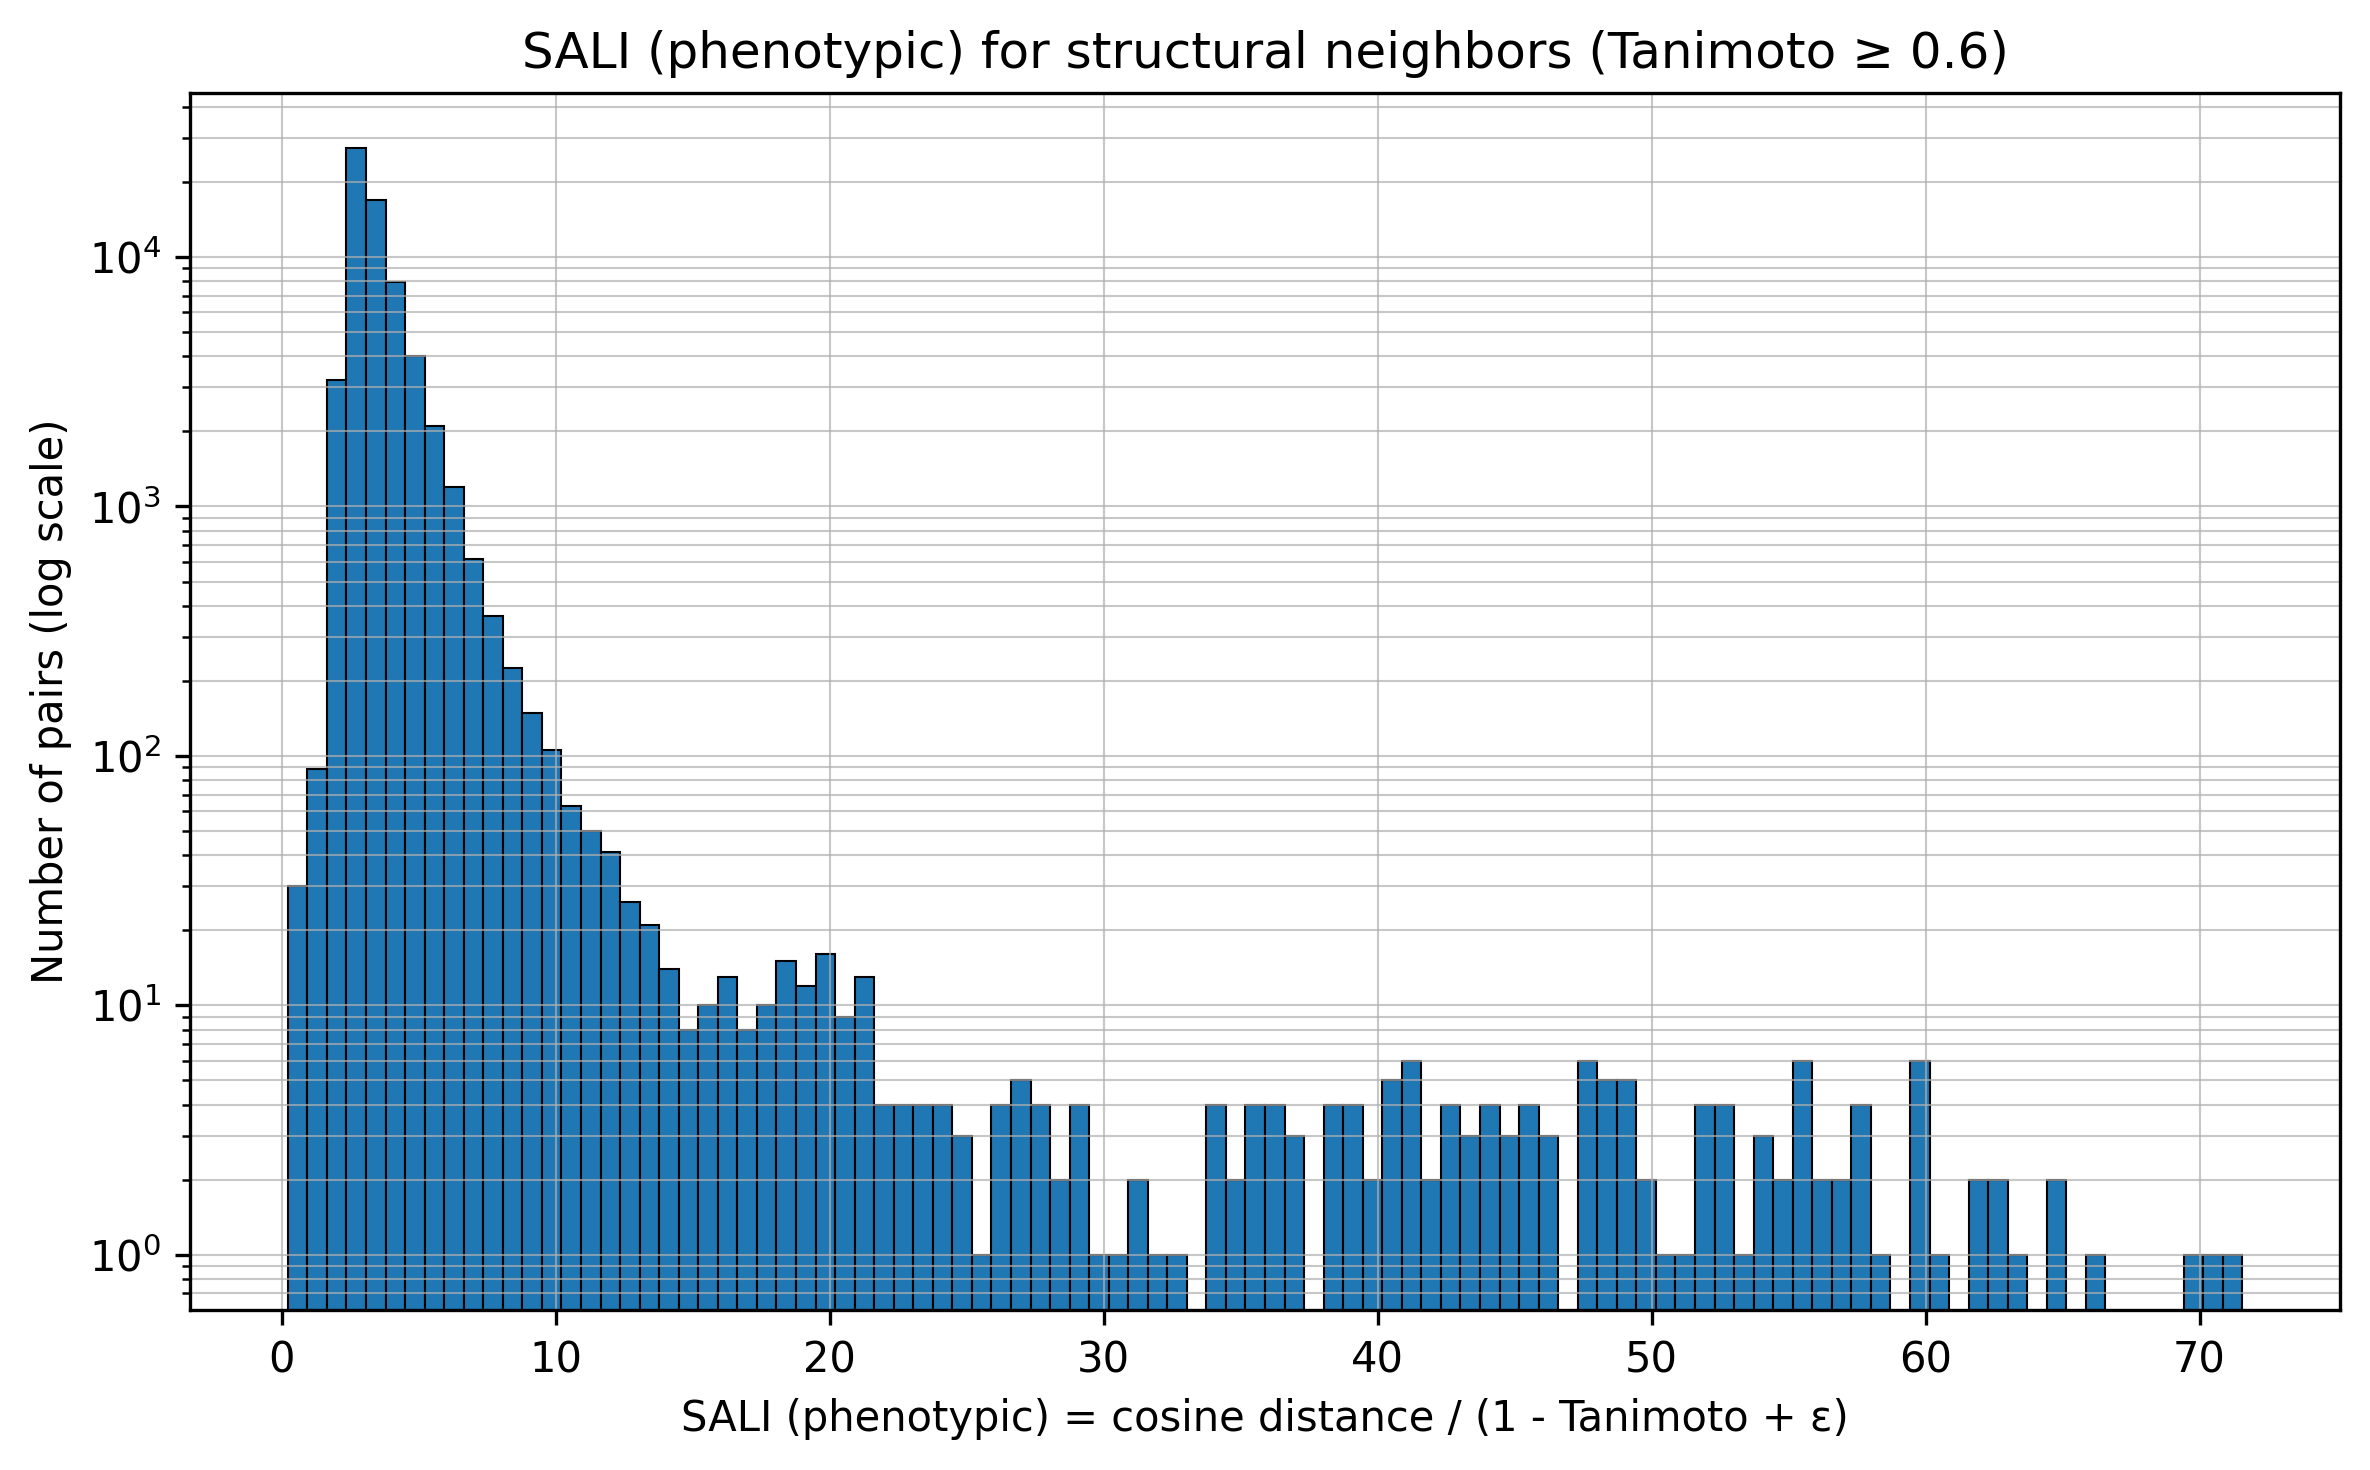

count    6.473300e+04
mean     9.233159e+02
std      3.044522e+04
min      2.234009e-01
25%      2.717315e+00
50%      3.129174e+00
75%      3.861829e+00
max      1.266018e+06
Name: SALI_pheno, dtype: float64


In [ ]:
# ---------------------------
# Histogramme HD (log-scale y)
# ---------------------------
plt.figure(figsize=(8, 5), dpi=300)
plt.hist(
    sali_df_no_outlier["SALI_pheno"].values,
    bins=100,
    edgecolor="black",
    linewidth=0.5,
)
plt.xlabel("SALI (phenotypic) = cosine distance / (1 - Tanimoto + ε)")
plt.ylabel("Number of pairs (log scale)")
plt.title(f"SALI (phenotypic) for structural neighbors (Tanimoto ≥ {TAN_THRESH})")
plt.yscale("log")
plt.tight_layout()
plt.grid(True, which="both", linewidth=0.5, alpha=0.7)
plt.show()

# Stats utiles
print(sali_df["SALI_pheno"].describe())

# HeatMap

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import norm
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

# ---------------------------
# Config
# ---------------------------
SUBSET_SIZE = 250  # keep small for a readable heatmap
FP_RADIUS = 2
FP_NBITS = 2048
EPS = 1e-8
ACTIVITY_METRIC = "euclidean"  # "cosine" (cosine angle in radians) or "euclidean"

# ---------------------------
# Pick a subset
# ---------------------------
idx = np.random.choice(len(jump_df), size=min(SUBSET_SIZE, len(jump_df)), replace=False)
df_sub = jump_df.iloc[idx].reset_index(drop=True).copy()
X_sub = embeddings[idx].astype(np.float32, copy=False)

labels = df_sub.get("Metadata_JCP2022", pd.Series(idx)).astype(str).tolist()


# ---------------------------
# Build fingerprints & Tanimoto matrix
# ---------------------------
def inchi_to_mol(inchi: str):
    try:
        return Chem.MolFromInchi(inchi, treatWarningAsError=False)
    except Exception:
        return None


def morgan_fp(mol, radius=FP_RADIUS, n_bits=FP_NBITS):
    return (
        None
        if mol is None
        else AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=n_bits)
    )


mols = [inchi_to_mol(s) for s in df_sub["Metadata_InChI"]]
fps = [morgan_fp(m) for m in mols]

# Tanimoto similarity matrix (n x n)
n = len(fps)
tan = np.zeros((n, n), dtype=np.float32)
for i, fpi in enumerate(fps):
    if fpi is None:
        continue
    sims = DataStructs.BulkTanimotoSimilarity(fpi, fps)  # list length n
    tan[i, :] = np.array([s if s is not None else 0.0 for s in sims], dtype=np.float32)

# ---------------------------
# Activity difference from embeddings
# ---------------------------
if ACTIVITY_METRIC == "cosine":
    # cosine similarity, then angle
    Xn = X_sub / np.maximum(norm(X_sub, axis=1, keepdims=True), 1e-12)
    cos = Xn @ Xn.T
    # cos = np.clip(cos, -1.0, 1.0)
    act = 1 - cos  # radians in [0, π]
elif ACTIVITY_METRIC == "euclidean":
    diffs = X_sub[:, None, :] - X_sub[None, :, :]
    act = norm(diffs, axis=2)  # Euclidean distance
else:
    raise ValueError("ACTIVITY_METRIC must be 'angle' or 'euclidean'.")

# ---------------------------
# SALI matrix
# ---------------------------
den = 1.0 - tan
den[den < EPS] = EPS  # numerical safety
sali = act / den

# Clean diagonal (self-pairs)
np.fill_diagonal(sali, np.nan)

# Optional: clip very large values for visualization
vmax = np.nanpercentile(sali, 99.5)
sali_vis = np.clip(sali, 0, vmax)

[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerat

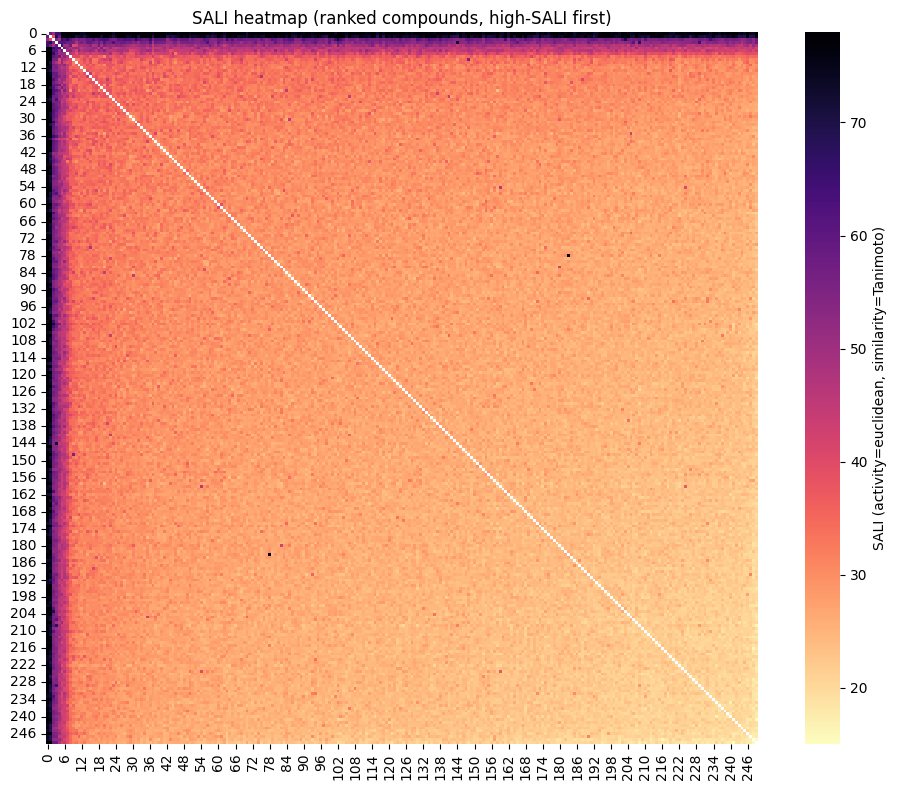

In [ ]:
# ---------------------------
# Rank compounds by mean SALI (ignoring NaN on diagonal)
# ---------------------------
sali_mean = np.nanmedian(sali, axis=1)  # moyenne par ligne
order = np.argsort(-sali_mean)  # tri décroissant (plus "cliff" d'abord)

# Réordonner matrice et labels
sali_vis_ord = sali_vis[order][:, order]
labels_ord = [labels[i] for i in order]

# ---------------------------
# Plot heatmap with inverted colormap
# ---------------------------
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    sali_vis_ord,
    cmap="magma_r",
    square=True,
    # xticklabels=labels_ord,
    # yticklabels=labels_ord,
    cbar_kws={"label": f"SALI (activity={ACTIVITY_METRIC}, similarity=Tanimoto)"},
    linewidths=0,
    linecolor="black",
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("SALI heatmap (ranked compounds, high-SALI first)")
plt.tight_layout()
plt.show()

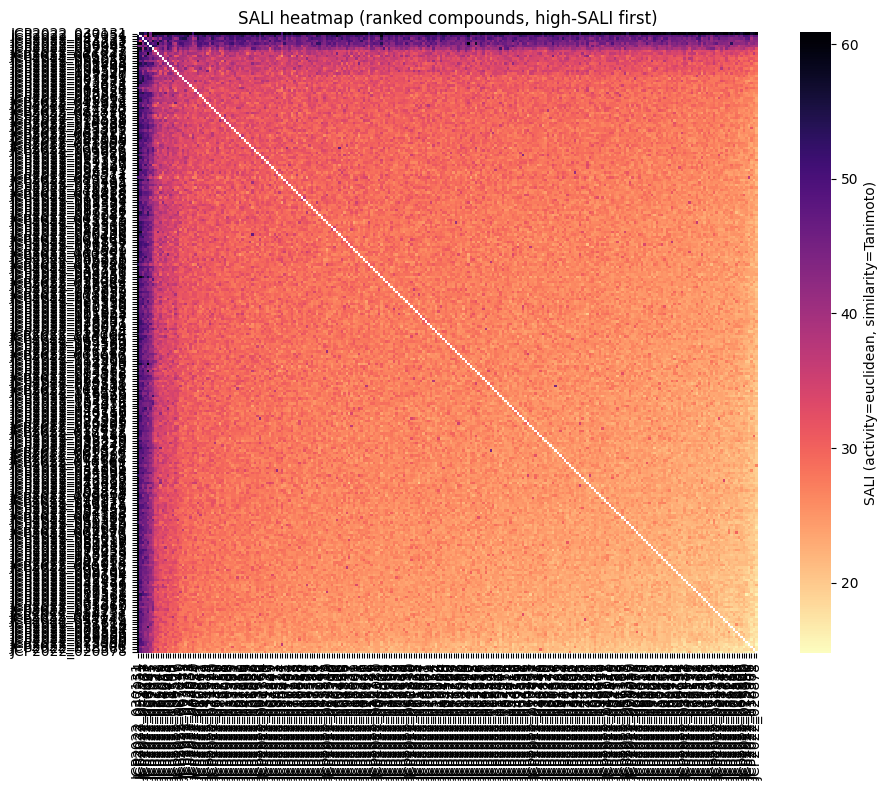

In [ ]:
# ---------------------------
# Rank compounds by mean SALI (ignoring NaN on diagonal)
# ---------------------------
sali_mean = np.nanmean(sali, axis=1)  # moyenne par ligne
order = np.argsort(-sali_mean)  # tri décroissant (plus "cliff" d'abord)

# Réordonner matrice et labels
sali_vis_ord = sali_vis[order][:, order]
labels_ord = [labels[i] for i in order]

# ---------------------------
# Plot heatmap with inverted colormap
# ---------------------------
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    sali_vis_ord,
    cmap="magma_r",
    square=True,
    xticklabels=labels_ord,
    yticklabels=labels_ord,
    cbar_kws={"label": f"SALI (activity={ACTIVITY_METRIC}, similarity=Tanimoto)"},
    linewidths=0,
    linecolor="black",
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("SALI heatmap (ranked compounds, high-SALI first)")
plt.tight_layout()
plt.show()